### Importing all modules

In [1]:
import pandas as pd
import random
import numpy as np
import spacy
import json
from nltk.corpus import wordnet, stopwords
import spacy

from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx
import matplotlib.pyplot as plt

import copy
import scipy

import pyttsx3

import warnings

warnings.filterwarnings('ignore')

# DATASET
[A link to the dataset] (https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge)
The dataset is of a millon articles about covid more details about the dataset is present in the link above.

### Reading and extracting data

In [2]:
# reading the metadata csv file
metadataDf = pd.read_csv("metadata.csv")
metadataDf

# Getting random 10000 samples based on the unique cord_uid which are thedocument ids
selectedLst = random.sample(list(metadataDf["cord_uid"].unique()), 10000)
#print(selectedLst)

# filtering the metadata csv dataframe to extract the randomly selected 10000 articles
selectedDF = metadataDf.loc[metadataDf["cord_uid"].isin(selectedLst)]

# for some reason there are duplicate entries of documents in the metedata so we have removed the duplicates here
selectedDF.drop_duplicates(subset = "cord_uid", keep = "first", inplace = True)


selectedDF.to_csv("selectedDF.csv", index=False)

In [3]:
selectedDF = pd.read_csv("selectedDF.csv")

In [4]:
sampled_articles = []

# looping through the selected Df
for i in range(len(selectedDF)):
    
    # this part is for the article Body
    if not pd.isna(selectedDF.iloc[i, 15]):
        # getting path for the pdf json file
        path = selectedDF.iloc[i, 15].split(";")[0]
        with open(path) as f:
            data = f.read()
            # opening the file from the path and loading the string from file to json
            articleJSON = json.loads(data)
    elif not pd.isna(selectedDF.iloc[i, 16]):
        path = selectedDF.iloc[i, 16].split(";")[0]
        with open(path) as f:
            articleJSON = json.loads(f.read())
    else:
        articleJSON = {"body_text" : []}
    
    articleBody = ""

    # appending the article body text from json file to one variable
    for i in articleJSON["body_text"]:
        articleBody += " \n" + i["text"]

    if len(articleBody) > 0:
        sampled_articles.append(articleBody)

### Preprocessing the data

In [5]:

# Download the necessary NLTK resources
#nltk.download('punkt')
#nltk.download('stopwords')

def preprocess_text(paragraphs):
    
    # Converting the text to lowercase
    text = paragraphs.lower()

    # replacing everything except alpha numeric and '-' characters just because we have importance to hyphens
    text = re.sub(r'[^a-zA-Z0-9 \- ]', ' ', text)

    return text


In [6]:
# Getting the english stopwords
stop_words = set(stopwords.words('english'))

# initialising the wordnet lemmatizer
wordnetLemmatizer = WordNetLemmatizer()

# this function is defined to give a tag for each word
def pos_tagger(nltk_tag):
    # We are checking what the nltk tag starts with and we are giving respective wordnet tag accepted by lemmatizer
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

# this function is defined to do the pre processing of the data (used it from my assignment 1)
def pre_processing(data):
    dataCopy = data
    # replacing everything except alpha numeric and '-' characters just because we have importance to hyphens
    dataCopy = re.sub(r'[^a-zA-Z0-9 \- ]', ' ', dataCopy)

    # tokenising the words
    dataCopy = word_tokenize(dataCopy)

    #checking if the word is not in stopwrods
    dataCopy = [word for word in dataCopy if word.lower() not in stop_words]

    # converting all the words to lower case
    dataCopy = [word.lower() for word in dataCopy]

    # getting the parts of speech tage for each word from nltk pos_tag function
    tagged_words = nltk.pos_tag(dataCopy)

    # applying the pos_tagger function to each word
    wordnet_tagged = [(x[0], pos_tagger(x[1])) for x in tagged_words]

    # once we get the tags wrt wordnet, we pass the word and its tage top the lammatizer
    dataCopy = [wordnetLemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    return dataCopy
    

In [7]:
# function for converting tokenised words to sentences
def make_sent(data):
    sent = ""
    for i in data:
        sent = sent + " " + i

    return sent

# this function is to build a dataframe of preprocessed documents
def preprocessed_DF():
    # initialising empty dataframe with columns
    finalDF = pd.DataFrame(columns = ["Doc number", "Preprocessed Sentence"])

    for i in range(len(selectedDF)):

        # this part is for the article Body
        if not pd.isna(selectedDF.iloc[i, 15]):
            path = selectedDF.iloc[i, 15].split(";")[0]
            with open(path) as f:
                data = f.read()
                articleJSON = json.loads(data)
        elif not pd.isna(selectedDF.iloc[i, 16]):
            path = selectedDF.iloc[i, 16].split(";")[0]
            with open(path) as f:
                articleJSON = json.loads(f.read())
        else:
            articleJSON = {"body_text" : []}
        
        articleBody = ""

        for j in articleJSON["body_text"]:
            articleBody += " " + j["text"]
        
        # checking if abstract is na
        if articleBody:

            # calling the pre_processing function on the string read fro the dataframe
            preProcessedBody = pre_processing(articleBody)

            # converting the above preprocessed tokens to sentence again
            preProcessedBodySent = make_sent(preProcessedBody)

            # adding that preprocessed sentence to the dataframe
            finalDF.loc[len(finalDF)] = [selectedDF.iloc[i, 0], preProcessedBodySent]

    return finalDF


### Named Entity Recognition and Knowledge Base

In [9]:

# Load pre-trained NER model
nlp = spacy.load('en_core_web_sm')

# Extracting entities and their associated names 
def extract_entities(preprocessed_paragraph):
    # Combine the tokens into a single string
    #text = ' '.join(preprocessed_paragraphs)
    # Process the text with the NER model
    doc = nlp(preprocessed_paragraph)
    # Extract the entities and their associated names
    entities = {}
    for ent in doc.ents:
        name = ent.text
        if ent.label_ in ['PERSON', 'ORG', 'GPE', 'PRODUCT', 'EVENT']:
            if name not in entities:
                entities[name] = []
            
            if ent.label_ not in entities[name] : entities[name].append(ent.label_)
        
        if ent.label_ == 'PRODUCT' and 'cov' in name.lower():
            if name not in entities:
                entities[name] = []
            entities[name].append('COVID_PRODUCT')
        elif ent.label_ == 'EVENT' and 'cov' in name.lower():
            if name not in entities:
                entities[name] = []
            entities[name].append('COVID_EVENT')
        elif ent.label_ == 'PERSON' and 'cov' in name.lower():
            if name not in entities:
                entities[name] = 
            entities[name].append('COVID_PERSON')            

    return entities

# Define a function to create a Knowledge Base from the extracted entities
def create_kb(entities, KB):
    for name, labels in entities.items():
        if name not in KB.keys(): KB[name] = [] 
        for entity in entities.keys():
            if entity != name and set(labels) == set(entities[entity]):
                KB[name].append(entity)
        if 'COVID_PRODUCT' in labels:
            KB[name].append('COVID-19')
        elif 'COVID_EVENT' in labels:
            KB[name].append('COVID-19')
        elif 'COVID_EVENT' in labels:
            KB[name].append('COVID-19')
    return KB

KB = {}
# Process each article in the sampled_articles list
for article in sampled_articles:
    # Get the paragraphs of the article
    paragraphs = article
    # Preprocess the text in each paragraph
    preprocessed_paragraphs = preprocess_text(paragraphs[:1000000])
    # Extract entities and their associated names from the preprocessed text
    entities = extract_entities(preprocessed_paragraphs)
    # Create a Knowledge Base from the extracted entities
    
    create_kb(entities, KB)
    # Use the KB for further analysis or queries on the text data


#### Visualising Knowledge Base

In [10]:
# Loop through a subset of the entities in the KB and print their canonical name and associated names
counter = 0
for name in KB.keys():
    if counter < 10:
        print(f"{counter+1}. {name} <-> {', '.join(KB[name])}")
        counter += 1
    else:
        break


1. irs <-> non-iris, cns tb-iris, haart, neuralgia, pcos mechanisms, pcos  ccr5, pharma ag, ccr5  ccl5, ibm corp   , miu, lifescan inc   milpitas, fisher  inc  waltham  ma  usa, mm01963251 s1   , prostaglandin e2, glp-1, the p-pi3k p-akt p-mtor, mbs720661, tx  usa, nih, p-mtor, the biorad micro protein electrophoresis, sinorica international, spss, spss inc   , glycogen, cholinesterase s  che s, qmeandisco, schr, schr dinger, emm, pvt  ltd   , cys328, phe438, hesperetin, the enolic hydroxyl group, fig, ache inhibitor, al   2004    , ase5, phic31, pbs, orco, linear, microsoft, ab5a, flank, ab1abc, inx3, al   2010, the new york city department of health and mental hygiene  garg  , new jersey department of health, illinois department of public health, covid-19 irs, the california department of public health  cdph, california department of public health, the california health interview survey, fig, johns hopkins university, al  fig, the tennessee valley healthcare system, fig, google, ibm,

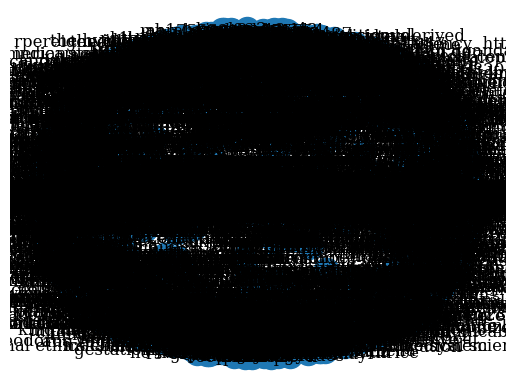

In [11]:

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for entity in KB.keys():
    G.add_node(entity)

# Add edges to the graph
for entity, relationships in KB.items():
    for related_entity in relationships:
        G.add_edge(entity, related_entity)

# Draw the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos, font_size=12, font_family="serif")
plt.axis("off")
plt.show()

In [1]:
# Building a knowledge base for the known entities
KB = {"covid-19" : ["coronavirus", "sarscov", "sarscovid", "sarscovid-19", "sars-cov-2", "corona"],
      "test" : ["swab test", "rapid antigen test", "rt-pcr"],
      "vaccine" : ["shot", "jab", "antibodies", "moderna", "covaxin", "covishield", "sputnik", "treatment"],
      "precautions" : ["quarantine", "mask", "avoid", "social distancing"],
      "trials" : ["medicine", "drug", "placebo", "effective"],
      "mortality" : ["death", "oxygen level", "repiratory"],
      "symptoms" : ["cold", "cough", "oxygen level", "tiredness"]}

### Inverted Indexing

In [13]:
# calling the preprocessed_DF function to get the dataframe with preprocessed documents
preProcessedDF = preprocessed_DF()

In [14]:
# initialising TF_IDF vectoriser
vectorizer = TfidfVectorizer()

# passing the final dataframe to the vectoriser
tfIdfVectors = vectorizer.fit_transform(preProcessedDF.loc[:, "Preprocessed Sentence"])

# converting the TF_IDF vectors to a dataframe so that it will be easy to fetch the top documents
tfIdfVectorsDF = pd.DataFrame(tfIdfVectors.toarray(), columns = vectorizer.get_feature_names_out(), index = preProcessedDF.loc[:, "Doc number"])


In [15]:
# initialising dictionary for inverted index
invertedIndexDict = {}

# iterating over the columns because our aech column is wrt a word 
for i in tfIdfVectorsDF.columns:
    invertedIndexDict[i] = {}
    # finding the top 10 documents for each word according to the TF_IDF value
    top10 = tfIdfVectorsDF[i].nlargest(10)

    # adding those top documents for each word in the inverted index
    for index, item in top10.iteritems():
        if item != 0:
            invertedIndexDict[i][index] = item

In [16]:
invertedIndexDict

{'00': {'x0wkz6d4': 0.5074016863487781,
  'gzjnb6yg': 0.20003502730659337,
  '0kyza0ay': 0.13249568513308263,
  '5t6b0nlk': 0.10867686483403294,
  'ocg5fgqr': 0.09830339059479823,
  'so1euw3b': 0.09358919640999136,
  'jk3el5vm': 0.09174113005290047,
  'lpar7tc8': 0.08835413562855546,
  '5qiy664a': 0.08354966164669972,
  '4rrc3w19': 0.07119109783340416},
 '000': {'tufaqn1j': 0.13143432388859258,
  'stg2ip1r': 0.11410553531384174,
  'gz5mln6w': 0.10488617107689244,
  '6w1rlaee': 0.09900144075244145,
  '3atl48x4': 0.09701388927630938,
  'h9whzsvx': 0.08147042557220738,
  '19cgdc9s': 0.07387732242393805,
  'w4qptaxv': 0.0730674109785811,
  '5e5cavkw': 0.07133911364372664,
  'h18cufbp': 0.0709750885408212},
 '0000': {'lktcv48e': 0.2782494160716025,
  'v3a2qmj5': 0.1361985533031596,
  'xzfxgsfw': 0.11142825789472015,
  'd1q1n5m8': 0.09139167644703453,
  'qubmr10h': 0.08311897332851019,
  '5sim1tju': 0.06229068574632137,
  'p2wbky8x': 0.05172532323539581,
  'wu1ortw2': 0.047658954580470515,
 

### Question Answering

In [17]:
from transformers import AutoTokenizer, AutoModel, pipeline, AutoModelForQuestionAnswering
from sentence_transformers import models, SentenceTransformer

In [18]:
# Take specific model and its correspoding tokenizer
tokenizerCovidBERT_NLI = AutoTokenizer.from_pretrained('gsarti/covidbert-nli')
modelCovidBERT_NLI = AutoModel.from_pretrained('gsarti/covidbert-nli')

# Save the model locally
modelCovidBERT_NLI.save_pretrained('/content')
tokenizerCovidBERT_NLI.save_pretrained('/content')

('/content\\tokenizer_config.json',
 '/content\\special_tokens_map.json',
 '/content\\vocab.txt',
 '/content\\added_tokens.json',
 '/content\\tokenizer.json')

we are getting the pre trained model and saving it locally

In [19]:
# Load the locally saved model
wordEmbeddingModel = models.Transformer('/content')


# Add the pooling strategy of Mean
poolingModel = models.Pooling(wordEmbeddingModel.get_word_embedding_dimension(),
                                   pooling_mode_mean_tokens=True,
                                   pooling_mode_cls_token=False,
                                   pooling_mode_max_tokens=False)

# create sentence encoder model along with pooling method
modelSentenceEncoder = SentenceTransformer(modules=[wordEmbeddingModel, poolingModel])



# creating a deep copy of the articles variable
mini_articles = sampled_articles[:]
embeddings = copy.deepcopy(mini_articles)

loading the locally sved model and adding pooling startegy.

our covidbert nli model is giving us contextualised word embeddings . we have vectors for each token. Then our pooling model converts all of them top a fixed length embedding.

In [20]:
# defining the pipeline we are going to use for getting our answers with respectivve models
modelQA = pipeline("question-answering", model = AutoModelForQuestionAnswering.from_pretrained("graviraja/covidbert_squad"), tokenizer = AutoTokenizer.from_pretrained("graviraja/covidbert_squad"))              

First param is task. Since ours is Qa we have put qa. then we put what model we are going to use for that particular task and similar with tokeniser.

In [21]:
# Returns the full sentence containing the answer from the context
def get_full_sentence(para_text, start_index, end_index):
    sent_start = 0
    sent_end = len(para_text)
    for sent in nlp(para_text).sents:
        if (sent.start_char <= start_index) and (sent.end_char >= start_index):
            sent_start = sent.start_char
        if (sent.start_char <= end_index) and (sent.end_char >= end_index):
            sent_end = sent.end_char
    sentence = para_text[sent_start:sent_end + 1]
    return sentence

In [22]:
# defined this function to get the top answers wrt to the query passed
def find_answers(query):

    query_embedding = modelSentenceEncoder.encode(query)
    queryPreprocessed = preprocess_text(query)
    queryTokens = word_tokenize(queryPreprocessed)
    queryTokensFinal = []

    # iterating through the query tokens to find similar entities from the Knowledge Base
    for word in queryTokens:
        queryTokensFinal.append(word)
        if word.lower() in KB.keys():
            queryTokensFinal.extend(KB[word])
        else:
            for key in KB.keys():
                if word.lower() in KB[key]:
                    queryTokensFinal.append(key)
                    queryTokensFinal.extend(KB[key])

    
    # just getting the unique values from the selected query tokens
    queryTokensFinal = list(set(queryTokensFinal))

    queryFinal = " ".join(queryTokensFinal)
    # calling the pre_processing function on query so that we have same tokens and we can fetch the top documents from inverted index dictionary.
    queryTokens = pre_processing(queryFinal)

    selectedDocs = {}

    # selecting the documens from the inverted index dictionary for each words and adding to the selectedDocs variable
    for token in queryTokens:
        if token in invertedIndexDict.keys():
            for doc in invertedIndexDict[token].keys(): selectedDocs[doc] = 0

    # initialising the answers list to store answers from all docs
    answers = []
    for doc in selectedDocs:

        if not pd.isna(selectedDF.loc[selectedDF["cord_uid"] == doc, 'pdf_json_files'].values[0]):
            path = selectedDF.loc[selectedDF["cord_uid"] == doc, 'pdf_json_files'].values[0].split(";")[0]
            with open(path) as f:
                data = f.read()
                articleJSON = json.loads(data)
        elif not pd.isna(selectedDF.loc[selectedDF["cord_uid"] == doc, 'pmc_json_files'].values[0]):
            path = selectedDF.loc[selectedDF["cord_uid"] == doc, 'pmc_json_files'].values[0].split(";")[0]
            with open(path) as f:
                articleJSON = json.loads(f.read())
        
        articleBody = ""

        for i in articleJSON["body_text"]:
            articleBody += " \n" + i["text"]

        # here we are removing the white spaces
        articleBody = articleBody.strip()
        if articleBody:
            # here we re splitting the whole article into paragraphs 
            articleBodyPara = articleBody.split("\n")

            queryToTextDistances = []
            for paraIdx, para in enumerate(articleBodyPara):
                # Encoding the paragraphs to get a vector
                body_text_embedding = modelSentenceEncoder.encode(para, show_progress_bar=False)

                #finding the distance between the query embedding and para embedding and adding it along with the index of para
                queryToTextDistances.append(((paraIdx, (1 - (scipy.spatial.distance.cdist([query_embedding], [body_text_embedding], "cosine")[0])))))

                # sorting the paragraphs wrt similarity with the query
                results = sorted(queryToTextDistances, key=lambda x: x[1], reverse=True)

            #looping through only top2 paragraphs to find the answers
            for paraId, _ in enumerate(results[:2]):
                # finding the paragraph wrt top index
                context = articleBodyPara[paraId]
                if len(context) > 0:
                    
                    #passing our query and top paragraphs as the context to find the answer
                    pred = modelQA({"context" : context, "question" : query}, top_k=1, show_progress_bar=False)

                    # if model finds the answer and the model confidence is more than 0 then adding it to the list
                    if pred["answer"] and round(pred["score"], 4) > 0:
                        # getting the relative snetence
                        sent = get_full_sentence(context, pred["start"], pred["end"])

                        # appending the (docid, score, answer and sentence) to answers list
                        answers.append((doc, round(pred["score"], 4), pred["answer"], sent))

    # if we find any answers then we are sorting them according to the scores from all docs and selecting top 5
    if len(answers) > 0:
        answers = sorted(answers, key=lambda x: x[1], reverse=True)[:5]

    # returning answers
    return answers


First we are encoding the query<br>
tokenise the query with preprocessing<br>
check in the KB. If any of the token is present in key or value of Kb then we add all other<br>
based on the new tokens we find the top10 articles wrt each query from the inverted index.<br>
once we have the selected documents, we get the article body, divide them into paragraph<br>
Then we encode each paragraph and check its similarity with query embedding.<br>
we select top 2 paragraph from each doc<br>
we then pass each of the 2 paragraph as context to our QA model with the query and we are getting the answer<br>

In [23]:
# list of example queries
queryList = ["what causes death from Covid-19?",
            "what drugs have been active against SARS-CoV or SARS-CoV-2 in animal studies?",
            "are there serological tests that detect antibodies to coronavirus?",
            "has social distancing had an impact on slowing the spread of COVID-19?",
            "what are best practices in hospitals and at home in maintaining quarantine?",
            "what are the transmission routes of coronavirus?",
            "are there any clinical trials available for the coronavirus",
            "what are the best masks for preventing infection by Covid-19?",
            "what type of hand sanitizer is needed to destroy Covid-19?",
            "what are the mortality rates overall and in specific populations",
            "what are the initial symptoms of Covid-19?",
            "what is known about those infected with Covid-19 but are asymptomatic?",
            "is remdesivir an effective treatment for COVID-19"]

In [24]:
# defining empty dict to store query and answers
ansDict = {}
for query in queryList:
    #print(query)
    # calling the function find_answers
    ans = find_answers(query)
    print(query , " : \n", ans)
    ansDict[query] = ans
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

# engine for spoken text
engine = pyttsx3.init()

for query, answers in ansDict.items():
    engine.say(query)
    engine.say(answers[0][3])
    
engine.runAndWait()


what causes death from Covid-19?  : 
 [('vnwlb1zw', 0.9413, 'COVID-19', 'Official COVID-19 mortality counts, around the world, largely rely on the attribution of COVID-19 as a cause of death on death certificates [1, 2, 3] . '), ('ppsutjw5', 0.8389, 'vitamin C deficiency', 'Therefore, we hypothesized that ARDS coronavirus disease 2019 (COVID-19) patients may present vitamin C deficiency. '), ('m1y1cpgm', 0.7594, 'HIV co-infection', 'Recently, a large-scale population-based study [19] with over 17 million individuals was performed in England to investigate the association of HIV co-infection and the risk of COVID-19 mortality, and found that people living with HIV had a higher risk of COVID-19 mortality than those without HIV after adjusting for age and sex (HR = 2.90, 95% CI 1.96-4.30). '), ('7hrll6u0', 0.6393, 'severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)', '2,3 COVID-19 is caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), 4 which has been associa

are there any clinical trials available for the coronavirus  : 
 [('fbkhwap7', 0.4155, 'a single clinically approved treatment could not be found', 'Many countries reported developing antiviral drugs or vaccines to control COVID-19; however, a single clinically approved treatment could not be found. '), ('0q5vt658', 0.3426, 'no specific pharmacological treatment that is effective against it is available', 'Because coronavirus disease 2019 (COVID-19) is associated with substantial morbidity and mortality,3 and no specific pharmacological treatment that is effective against it is available, chloroquine and chloroquine-related formulations have been tentatively included among drugs for use in limiting the total burden of COVID-19.4, 5 However, no studies have evaluated the use of chloroquine for prophylaxis. '), ('8kvso7k9', 0.3106, 'Recently published studies', 'Recently published studies have found that this virus belongs to the beta-BAT-SARS-CoV-2 and has some essential amino acids for

'engine = pyttsx3.init()\n\nfor query, answers in ansDict.items():\n    engine.say(query)\n    engine.say(answers[0][3])\n    \nengine.runAndWait()\n'

In [25]:
# function for sending a query with option to get spoken text
def get_answers(query, spoken = True):
    ans = find_answers(query)
    print(query , " : \n", ans)
    
    if spoken:
        engine = pyttsx3.init()
        engine.say(query)
        engine.say(ans[0][3])
    
        engine.runAndWait()


### User interface to ask query

In [ ]:
query = input("Enter your query : ")
spokenFlag = input("Enter if you want spoken answer (T/F): ")

if spokenFlag.lower() == "t":
    get_answers(query, True)
else:
    get_answers(query, False)